## Load Data and Initial Grid Search

In [1]:
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "CDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\pastis\\wavelet\\approx1e5\\gray'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
data_dir = os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle')
group_data_map = pd.read_pickle(data_dir)
GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
group_data_map

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -36.2290875 , -34.21402956, ...,  32.91894773,
         36.11999915,  42.17747737]),
 6: array([-23.87540781, -21.69502371, -19.77842932, ...,  18.532206  ,
         21.00124659,  44.79754701]),
 7: array([-19.12997336, -11.63154378, -10.24156022, ...,  10.34018388,
         11.58181396,  20.30569957]),
 8: array([-18.71256003,  -5.38310051,  -4.75432793, ...,   4.71546986,
          5.46900035,  20.5891778 ])}

In [5]:
''' Only need to run commented code once'''
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])
all_cdfs_df['variance'] = np.nan_to_num(all_cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
all_cdfs_df['kurtosis'] = all_cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
group_cdf_df_dict = dict()

all_cdfs_df.head()

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:787: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:792: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:792: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:792: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, 0), <scipy.interpolate._fitpack2.Inter...",0.02,0.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,4.553186e+99,NaN
1,"((0.02, 0.1), <scipy.interpolate._fitpack2.Int...",0.02,0.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.560477e+100,NaN
2,"((0.02, 0.2), <scipy.interpolate._fitpack2.Int...",0.02,0.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,6.013272e+101,NaN
3,"((0.02, 0.3), <scipy.interpolate._fitpack2.Int...",0.02,0.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.824903e+102,NaN
4,"((0.02, 0.4), <scipy.interpolate._fitpack2.Int...",0.02,0.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.104347e+103,NaN


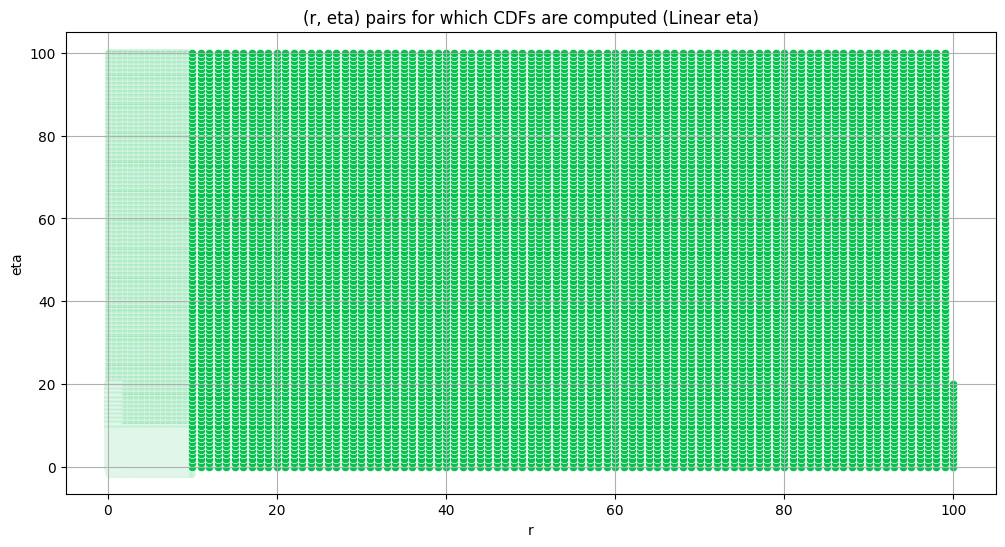

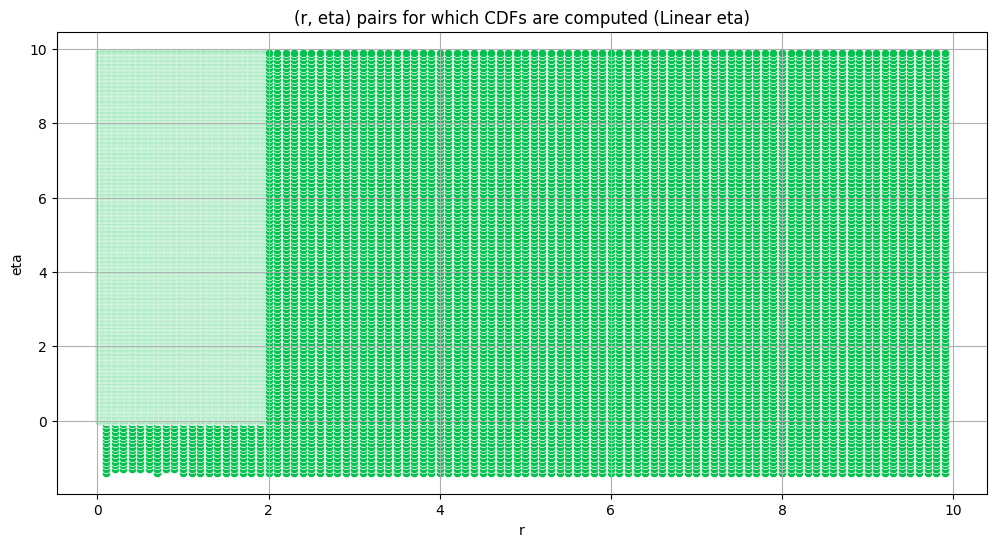

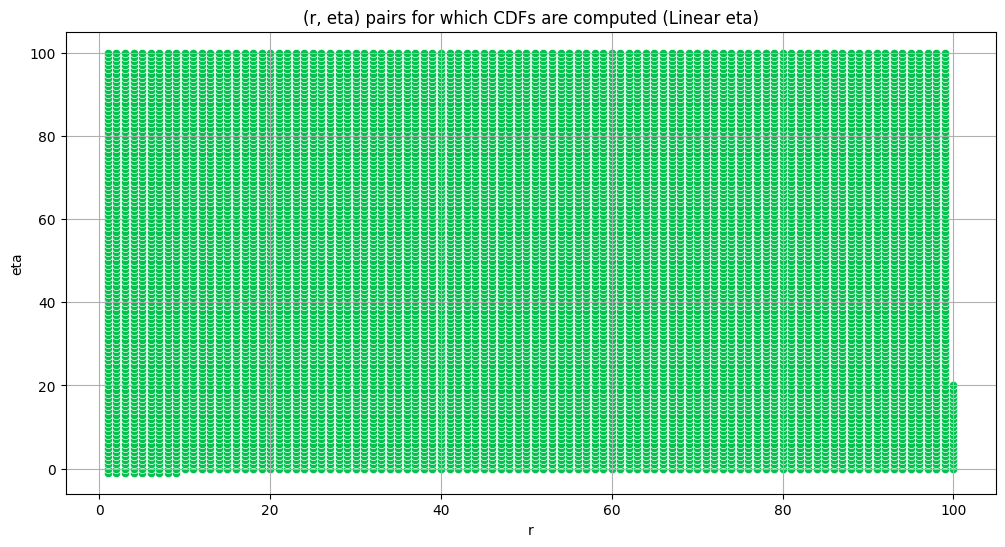

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,r,eta,variance,kurtosis
count,49356.000000,49356.000000,4.935600e+04,4.812000e+04
mean,12.550652,22.614379,inf,inf
std,23.072257,28.488261,inf,NaN
min,0.020000,-1.400000,0.000000e+00,4.787254e-04
25%,1.040000,3.700000,9.924824e-01,1.305569e-02
50%,2.400000,8.000000,1.528212e+00,1.709859e-01
75%,8.400000,35.000000,5.855025e+00,5.394159e-01
max,100.000000,100.000000,1.797693e+308,inf


In [6]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [7]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99
eps_var = 50
eps_kurt = 5

In [9]:
''' Only need to run commented code once'''    
for group in  GROUPS:
    print(f'\n {GROUP.capitalize()} {group}')
    obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], n_bootstrap=n_bootstrap, bootstrap_size=min(group_data_map[group].size, bootstrap_size), metric= np.var, ci=ci)
    obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], n_bootstrap=n_bootstrap, bootstrap_size=min(group_data_map[group].size, bootstrap_size), metric= stats.kurtosis, ci=ci)  
    group_cdf_df = all_cdfs_df.copy()
    group_cdf_df['pass_var'] = (group_cdf_df['variance'] > var_lower) & (group_cdf_df['variance'] < var_upper)
    group_cdf_df['pass_kurt'] = (group_cdf_df['kurtosis'] > kurt_lower) & (group_cdf_df['kurtosis'] < kurt_upper)
    group_cdf_df['pass_eps_var'] = (group_cdf_df['variance'] > var_lower - eps_var) & (group_cdf_df['variance'] < var_upper + eps_var)
    group_cdf_df['pass_eps_kurt'] = (group_cdf_df['kurtosis'] > kurt_lower - eps_kurt) & (group_cdf_df['kurtosis'] < kurt_upper + eps_kurt)

    master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
    master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
    group_cdf_df_dict[group] = group_cdf_df
    fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    plt.close(fig_var)
    fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    plt.close(fig_kurt)
pd.to_pickle(var_values_dict, os.path.join(CWD, "cache", f'var_values_dict_{n_bootstrap}_{bootstrap_size}.pickle'))
pd.to_pickle(kurt_values_dict, os.path.join(CWD, "cache", f'kurt_values_dict_{n_bootstrap}_{bootstrap_size}.pickle'))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_initial.pickle"))
master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_initial.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper
layer,,,,,,
2,803.473892,711.441914,913.081662,0.094996,-0.224301,0.434156
3,275.270192,243.028673,310.885561,0.374403,-0.095163,0.867555
4,80.847728,70.301794,92.837725,1.357251,0.481414,3.469828
5,19.882305,16.165884,24.169638,3.074957,1.348590,11.985223
6,4.187365,3.272019,6.044697,7.592764,2.422304,101.032479
7,0.819285,0.615090,1.230614,13.123555,3.820039,122.128186
8,0.136744,0.095568,0.551345,172.661568,4.900300,605.121536


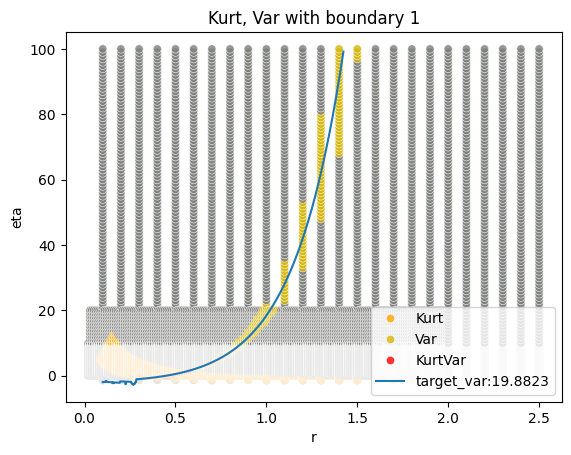

Lowest eta value: -2.0006894553021195


<Axes: title={'center': 'Kurt, Var with boundary 1'}, xlabel='r', ylabel='eta'>

In [10]:
# Example cell
group = 5
combo_test_plot(group_cdf_df_dict[group], ['pass_var','pass_kurt'], target_var = master_df.loc[group, 'obs_var'], extra_boundary=1)

####
Layer  2


100%|██████████| 49356/49356 [00:00<00:00, 54443.30it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 4, Without approximation : 3180.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:813: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


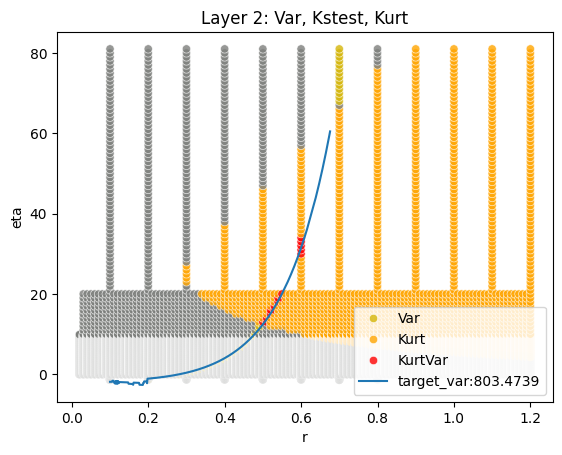

Lowest eta value: -1.8699283631751105
####
Layer  3


100%|██████████| 49356/49356 [00:01<00:00, 47891.22it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 13, Without approximation : 12720.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:813: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


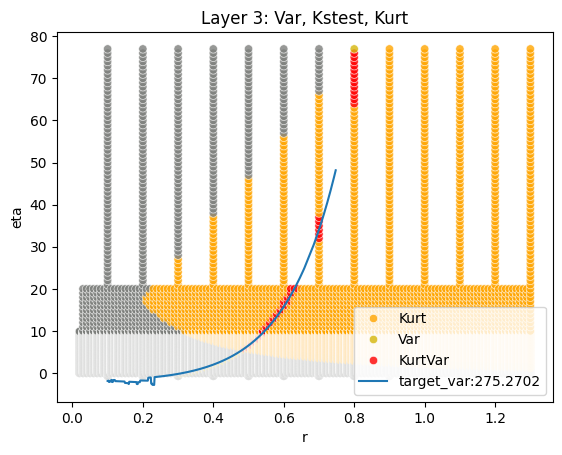

Lowest eta value: -1.8904985072030835
####
Layer  4


100%|██████████| 49356/49356 [00:02<00:00, 22408.87it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 51, Without approximation : 50880.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:813: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


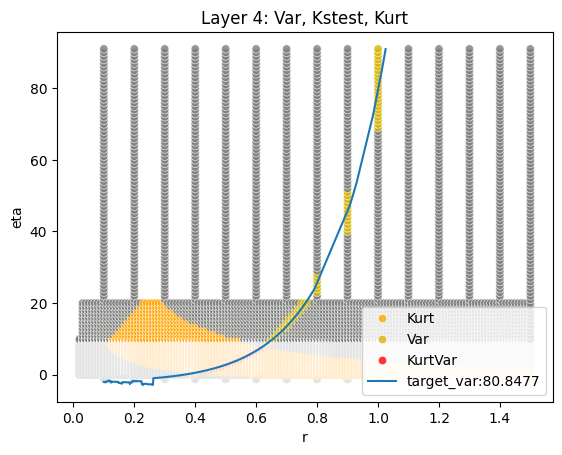

Lowest eta value: -2.0027947159845723
####
Layer  5


100%|██████████| 49356/49356 [00:02<00:00, 18136.98it/s]


Finding Minimum after computing 49356 CDFs
Number of samples: 100, Without approximation : 203520.0


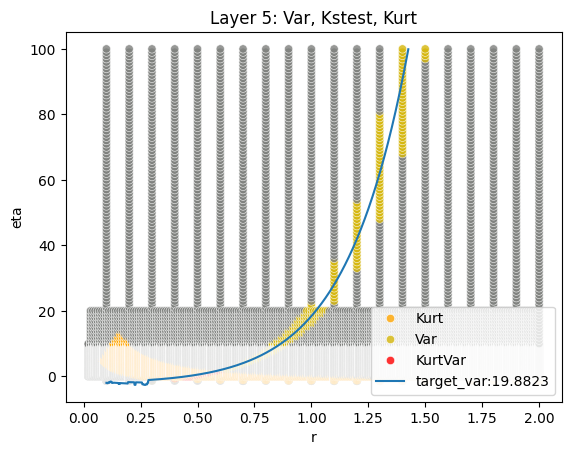

Lowest eta value: -2.0006894553021195
####
Layer  6


100%|██████████| 49356/49356 [00:05<00:00, 9715.92it/s] 


Finding Minimum after computing 49356 CDFs
Number of samples: 100, Without approximation : 814080.0


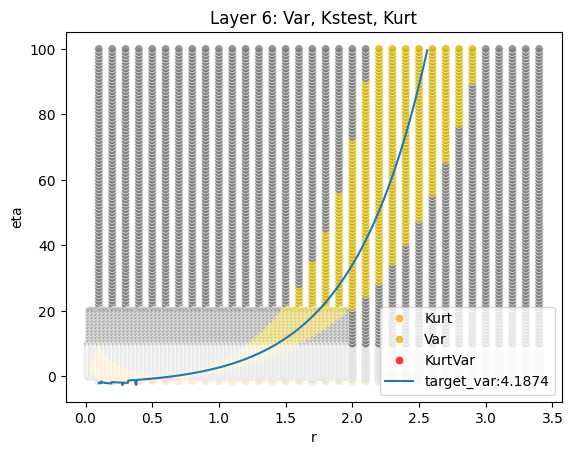

Lowest eta value: -2.0001453530785485
####
Layer  7


100%|██████████| 49356/49356 [00:05<00:00, 9344.29it/s] 


Finding Minimum after computing 49356 CDFs
Number of samples: 100, Without approximation : 3256320.0


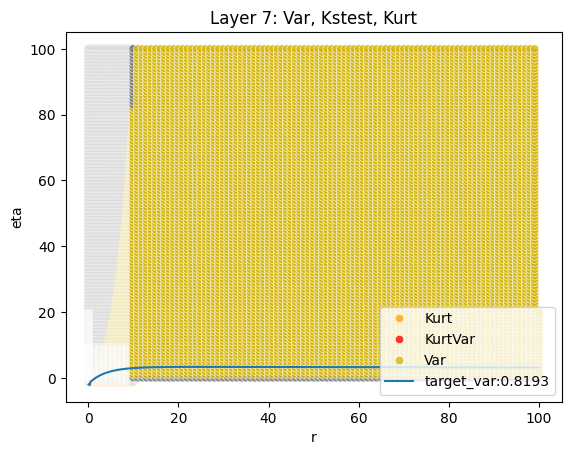

Lowest eta value: -2.0000284458959667
####
Layer  8


100%|██████████| 49356/49356 [00:05<00:00, 9333.47it/s] 


Finding Minimum after computing 49356 CDFs
Number of samples: 100, Without approximation : 13025280.0


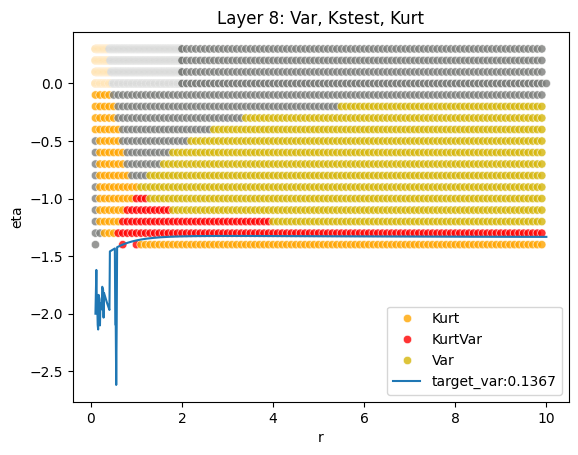

Lowest eta value: -2.0000047481104946


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,initial_r,initial_eta,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,
2,803.473892,711.441914,913.081662,0.094996,-0.224301,0.434156,0.20,-0.5,3180.0,0.181086,0.024030
3,275.270192,243.028673,310.885561,0.374403,-0.095163,0.867555,0.39,2.1,12720.0,0.075487,0.012029
4,80.847728,70.301794,92.837725,1.357251,0.481414,3.469828,0.45,1.6,50880.0,0.019451,0.006018
5,19.882305,16.165884,24.169638,3.074957,1.348590,11.985223,0.46,0.1,203520.0,0.014423,0.003010
6,4.187365,3.272019,6.044697,7.592764,2.422304,101.032479,0.50,-0.6,814080.0,0.016837,0.001505
7,0.819285,0.615090,1.230614,13.123555,3.820039,122.128186,1.00,-0.9,3256320.0,0.020512,0.000753
8,0.136744,0.095568,0.551345,172.661568,4.900300,605.121536,7.20,-1.3,13025280.0,0.030000,0.000376


In [12]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'full-pastis-wavelet-gray-size.pickle'))

for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    group_cdf_df = group_cdf_df_dict[group]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    master_df.loc[group, 'total_samples'] = group_total_samples[group]
    print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff
    group_cdf_df['ksstat'] = ksstats
    group_cdf_df['pass_kstest'] = group_cdf_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_test_plot(group_cdf_df_dict[group], cols, plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", target_var = master_df.loc[group, 'obs_var'])
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"), index_col=GROUP)
master_df

In [13]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(GROUPS):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        group_cdfs = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, group_cdfs, debug=True)
        best_params_eta0.append(best_param_eta0[0])
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append(master_df.loc[group, 'initial_r'])
master_df['best_r_eta0'] = best_params_eta0
master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"), index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,initial_r,initial_eta,num_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0
layer,,,,,,,,,,,,,
2,803.473892,711.441914,913.081662,0.094996,-0.224301,0.434156,0.42,5.5,3180.0,0.029241,0.024030,0.060346,0.26
3,275.270192,243.028673,310.885561,0.374403,-0.095163,0.867555,0.48,5.6,12720.0,0.007752,0.012029,0.037012,0.29
4,80.847728,70.301794,92.837725,1.357251,0.481414,3.469828,0.44,1.4,50880.0,0.006307,0.006018,0.023319,0.34
5,19.882305,16.165884,24.169638,3.074957,1.348590,11.985223,0.46,0.1,203520.0,0.005646,0.003010,0.005653,0.44
6,4.187365,3.272019,6.044697,7.592764,2.422304,101.032479,0.50,-0.6,814080.0,0.007916,0.001505,0.020507,0.74
7,0.819285,0.615090,1.230614,13.123555,3.820039,122.128186,1.00,-0.9,3256320.0,0.011579,0.000753,0.082284,6.10
8,0.136744,0.095568,0.551345,172.661568,4.900300,605.121536,0.70,-1.3,13025280.0,0.029000,0.000376,0.227351,6.00


In [26]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, use_matlab=True, eng=None, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)

    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            # if computed_cdf is None:
            #     with open("generate_CDF_log_yash.csv", 'a') as handle:
            #         handle.write(f"{r}, {eta}, {n_samples}, failed assert\n")
            #     continue
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}-{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [6]:
SKIP_OPTIMIZE_STEP = False

if SKIP_OPTIMIZE_STEP:
    master_df['kstest_stat'] = master_df['kstest_stat_initial']
    master_df[f'best_r'] = master_df['initial_r']
    master_df[f'best_eta'] = master_df['initial_eta']
else:
    for group in GROUPS: 
        sample = group_data_map[group]
        initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']
        r_granularity = 10
        eta_granularity = 10
        for i in range(0, -5, -1):
            if tuple(initial_param + np.array([10.**i, 0])) in all_cdfs:
                r_granularity = 10.**i
            if tuple(initial_param + np.array([0, 10.**i])) in all_cdfs:
                eta_granularity = 10.**i

        r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
        eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]

        simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "CDFs"), folder_name=f'{GROUP}{group}', n_samples = 200, debug=False)
        group_cdfs = combine_pickles(os.path.join(CWD, "CDFs", f'{GROUP}{group}'))
        ksstats, best_param, kstest_stat = gridsearch(sample, group_cdfs, debug=True)
        master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
        master_df.loc[group, 'kstest_stat_best'] = kstest_stat
        print(f"{GROUP} {group} best parameters: {best_param, master_df.loc[group, 'kstest_stat_best']}")

master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', f'best_r', f'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,initial_r,initial_eta,total_samples,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_eta0,best_r_eta0,best_r,best_eta,kstest_stat_best,n_pval_0.05
layer,,,,,,,,,,,,,,,,,
2,803.473892,711.441914,913.081662,0.094996,-0.224301,0.434156,0.42,5.5,3180.0,0.029241,0.024030,0.060346,0.26,0.42,5.59,0.020879,4023
3,275.270192,243.028673,310.885561,0.374403,-0.095163,0.867555,0.48,5.6,12720.0,0.007752,0.012029,0.037012,0.29,0.48,5.51,0.004314,96592
4,80.847728,70.301794,92.837725,1.357251,0.481414,3.469828,0.44,1.4,50880.0,0.006307,0.006018,0.023319,0.34,NaN,NaN,NaN,-1
5,19.882305,16.165884,24.169638,3.074957,1.348590,11.985223,0.46,0.1,203520.0,0.005646,0.003010,0.005653,0.44,NaN,NaN,NaN,-1
6,4.187365,3.272019,6.044697,7.592764,2.422304,101.032479,0.50,-0.6,814080.0,0.007916,0.001505,0.020507,0.74,NaN,NaN,NaN,-1
7,0.819285,0.615090,1.230614,13.123555,3.820039,122.128186,1.00,-0.9,3256320.0,0.011579,0.000753,0.082284,6.10,NaN,NaN,NaN,-1
8,0.136744,0.095568,0.551345,172.661568,4.900300,605.121536,0.70,-1.3,13025280.0,0.029000,0.000376,0.227351,6.00,NaN,NaN,NaN,-1


## Comparing Empirical and Computed CDF/PDF

Params: 0.48, 5.6
Chebyshev bound: 542.9628665002974
Tail samples: 20


100%|██████████| 100/100 [00:00<00:00, 264.06it/s]


First CDF value: 1.4966009889982855e-25
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.013178462145813807, pvalue=0.061472706625704254, statistic_location=-12.372441964960082, statistic_sign=1)


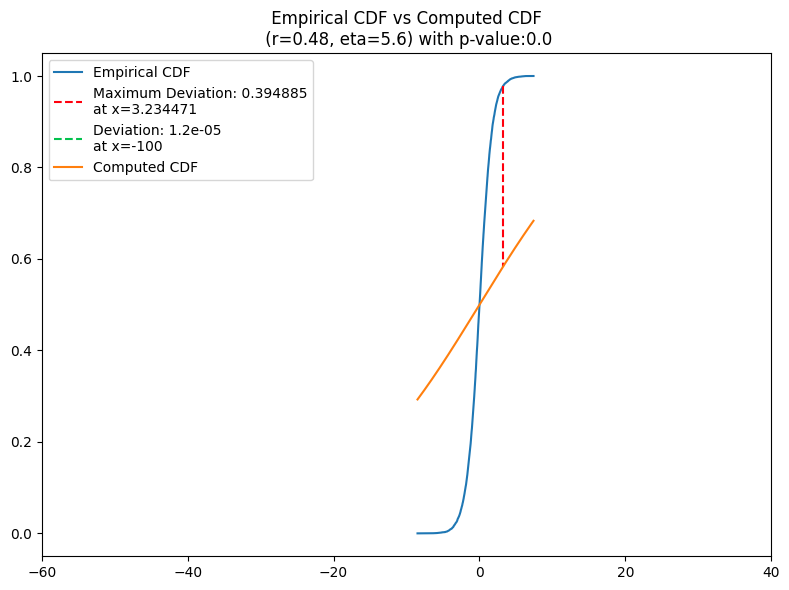

In [11]:
# Example Cell
group = 3
visualize_cdf(sample = sample_prior(1, 1, 10000), 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace

In [ ]:
for group in GROUPS:
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_compare_priors.csv'), index_col = GROUP)
master_df

# Examining Tail Behavior

In [ ]:
bw = 0.05
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_7.jpg'), bbox_inches = 'tight')

bw = 0.05
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(os.path.join(CWD, "plots", 'log-log_plot_layer_8.jpg'), bbox_inches = 'tight')

In [ ]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
            elif distro == 'gaussian':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in GROUPS:
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

# Results

## KS-Test Statistics

In [ ]:
#master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')
